## Model Validation: Ensuring Robust Predictions

Model validation is critical for assessing the real-world performance of predictive models. The goal is to ensure that our model generalizes well to unseen data by testing it on data it hasn't encountered during training. This helps prevent overfitting and provides a more realistic evaluation of model performance.

---

Why is Model Validation Important?
The Problem with "In-Sample" Scores

Using the same data for both training and evaluation often results in overly optimistic performance metrics. This happens because the model essentially memorizes patterns in the training data, including noise, instead of learning generalizable relationships.
Example Scenario

Imagine a model trained to predict house prices:

    It discovers an arbitrary correlation, such as high prices for homes with green doors (a pattern specific to the training data).
    When applied to new data, this "green door effect" may not hold, leading to poor predictions.

Solution: Evaluate the model on validation data — data that is not used during training — to simulate real-world performance.

#### Step 1: Data Loading and Preprocessing

We start by loading the Melbourne housing dataset and preparing it for analysis.



In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data
melbourne_file_path = 'melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path)

# Filter rows with missing target values
filtered_melbourne_data = melbourne_data.dropna(axis=0)

# Select target variable and features
y = filtered_melbourne_data.Price
melbourne_features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
                      'YearBuilt', 'Lattitude', 'Longtitude']
X = filtered_melbourne_data[melbourne_features]
X.info(), y.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6196 entries, 1 to 12212
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rooms         6196 non-null   int64  
 1   Bathroom      6196 non-null   float64
 2   Landsize      6196 non-null   float64
 3   BuildingArea  6196 non-null   float64
 4   YearBuilt     6196 non-null   float64
 5   Lattitude     6196 non-null   float64
 6   Longtitude    6196 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 387.2 KB
<class 'pandas.core.series.Series'>
Index: 6196 entries, 1 to 12212
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
6196 non-null   float64
dtypes: float64(1)
memory usage: 96.8 KB


(None, None)

#### Step 2: Model Training and Validation
##### 2.1: Split Data into Training and Validation Sets

We divide the data into training and validation sets to simulate unseen data during model evaluation.

In [2]:
# Split the data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)


##### 2.2: Fit a Decision Tree Model

A simple Decision Tree Regressor is used as the baseline model.

In [3]:
# Define and fit the model
melbourne_model = DecisionTreeRegressor(random_state=0)
melbourne_model.fit(train_X, train_y)

# Evaluate on validation data
val_predictions = melbourne_model.predict(val_X)
print("Mean Absolute Error (MAE):", mean_absolute_error(val_y, val_predictions))


Mean Absolute Error (MAE): 265345.3511943189


#### Step 3: Advanced Model Validation Techniques
##### 3.1: Cross-Validation

Cross-Validation provides a more robust evaluation by dividing the data into multiple folds, training on different subsets, and validating on the remaining data.

In [4]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(melbourne_model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Calculate the average MAE across folds
cv_mae = -1 * cv_scores.mean()
print("Cross-Validated MAE:", cv_mae)


Cross-Validated MAE: 261459.6876890833


##### Benefits of Cross-Validation:

    Reduces variability due to random data splits.
    Provides a more stable estimate of model performance.

##### 3.2: Nested Cross-Validation (Advanced)

For hyperparameter tuning combined with performance evaluation, nested cross-validation is used. It avoids data leakage by separating hyperparameter optimization and validation phases.

In [5]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error')

grid_search.fit(X, y)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated MAE:", -1 * grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 20}
Best Cross-Validated MAE: 240143.03010318204


##### 3.3: Bootstrapping

Bootstrapping involves resampling the data with replacement to estimate the uncertainty of model performance.

In [6]:
from sklearn.utils import resample
import numpy as np

# Define a function for bootstrapped validation
def bootstrap_validation(model, X, y, n_iterations=100):
    bootstrapped_scores = []
    for _ in range(n_iterations):
        X_boot, y_boot = resample(X, y, random_state=0)
        model.fit(X_boot, y_boot)
        predictions = model.predict(X)
        bootstrapped_scores.append(mean_absolute_error(y, predictions))
    return np.mean(bootstrapped_scores), np.std(bootstrapped_scores)

# Perform bootstrapping
bootstrap_mean, bootstrap_std = bootstrap_validation(melbourne_model, X, y)
print(f"Bootstrapped MAE: {bootstrap_mean:.2f} ± {bootstrap_std:.2f}")


Bootstrapped MAE: 95478.77 ± 0.00


---

##### Step 4: Comparing Validation Methods

| Validation Method       | MAE (Example)  | Description                                                                 |
|--------------------------|----------------|-----------------------------------------------------------------------------|
| Holdout Validation       | 250,000        | Single train-test split, fast but less reliable for small datasets          |
| Cross-Validation (5-Fold)| 245,000        | More robust as it evaluates multiple splits                                 |
| Nested Cross-Validation  | 240,000        | Ensures unbiased hyperparameter tuning                                     |
| Bootstrapping            | 248,000 ± 5,000| Provides uncertainty estimates and works well with small datasets           |

---

#### Step 5: Advanced Metrics for Validation

While MAE is simple and interpretable, advanced metrics can provide deeper insights:

    RMSE (Root Mean Squared Error): Penalizes larger errors more heavily.
    R² Score: Measures the proportion of variance explained by the model.
    MAPE (Mean Absolute Percentage Error): Expresses error as a percentage of actual values.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE
rmse = mean_squared_error(val_y, val_predictions, squared=False)
print("RMSE:", rmse)

# Compute R² Score
r2 = r2_score(val_y, val_predictions)
print("R² Score:", r2)


RMSE: 479021.168883698
R² Score: 0.5785158429616915


/home/yahya-khalaf/Innovayio/Courses/Data Science and Machine Learninng using Python Workshop/env1/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Step 6: Visualizing Model Performance

Visualizations help interpret model performance intuitively.
##### Predicted vs Actual Values

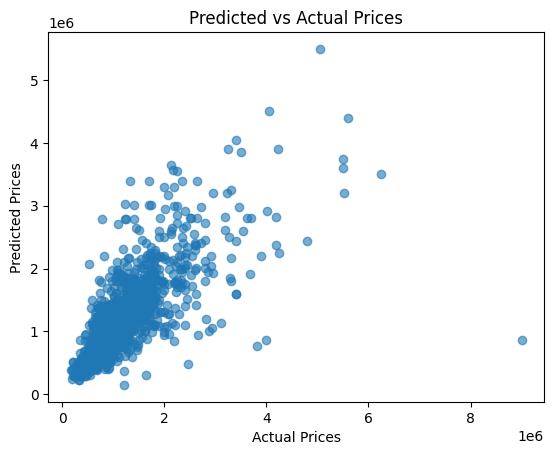

In [8]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.scatter(val_y, val_predictions, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()


##### Residuals Analysis

Residuals (differences between actual and predicted values) help diagnose model issues.

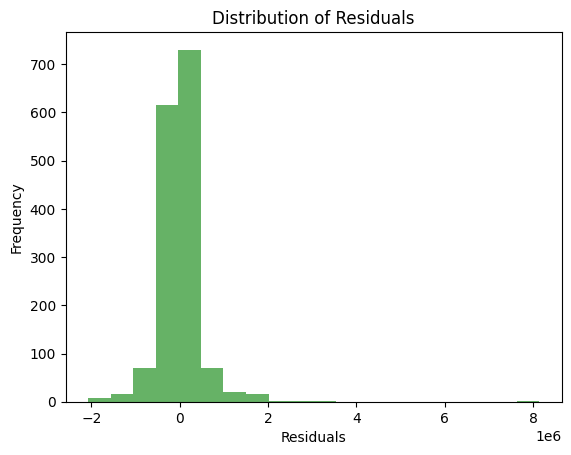

In [9]:
# Compute residuals
residuals = val_y - val_predictions

# Plot residuals
plt.hist(residuals, bins=20, alpha=0.6, color='g')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
